# Random Forest for Loan Default Prediction

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import beepy 

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV 
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_68199/4284180813.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We should generally avoid looking at the entire data set to prevent data leakage, but we have to look at the outcome variable first to determine if there is sever class imbalance, and to fix some other things like categorical variables. 

In [3]:
default_data = pd.read_csv("Loan_default.csv") 
default_data

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


Things to note:
- Class imbalance of the outcome 'Default'
- Categorical variables should be encoded either using OneHotEncoding or CatBoost


In [4]:
default_data.drop('LoanID', axis=1, inplace=True) 

## Data Splits

In [5]:
default_train, default_test = train_test_split(
                                                default_data, test_size = 0.3, random_state = 42, 
                                                stratify = default_data["Default"]) 
#We want to stratify by the outcome var to make sure we have enough defaulting observations 

In [6]:
print(default_train.shape)
print(default_test.shape)

(178742, 17)
(76605, 17)


## EDA

In [7]:
n = default_train["Default"].value_counts()
prop = n/len(default_train)
print(prop)

Default
0    0.883872
1    0.116128
Name: count, dtype: float64


We see that there is a sever class imbalance. We ought to fix this, as otherwise the model may just over-predict negative outcomes and still get very high accuracy.

In [12]:
default_train['Education']

12729             PhD
231880    High School
220618     Bachelor's
83560             PhD
156780    High School
             ...     
59108        Master's
71610             PhD
85645     High School
21010     High School
7493         Master's
Name: Education, Length: 178742, dtype: object

In [13]:
#default_train.groupby('Education').mean()

In [14]:
default_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178742 entries, 12729 to 7493
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             178742 non-null  int64  
 1   Income          178742 non-null  int64  
 2   LoanAmount      178742 non-null  int64  
 3   CreditScore     178742 non-null  int64  
 4   MonthsEmployed  178742 non-null  int64  
 5   NumCreditLines  178742 non-null  int64  
 6   InterestRate    178742 non-null  float64
 7   LoanTerm        178742 non-null  int64  
 8   DTIRatio        178742 non-null  float64
 9   Education       178742 non-null  object 
 10  EmploymentType  178742 non-null  object 
 11  MaritalStatus   178742 non-null  object 
 12  HasMortgage     178742 non-null  object 
 13  HasDependents   178742 non-null  object 
 14  LoanPurpose     178742 non-null  object 
 15  HasCoSigner     178742 non-null  object 
 16  Default         178742 non-null  int64  
dtypes: float64(2)

In [12]:
default_train.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,178742.000000,178742.000000,178742.000000,178742.000000,178742.000000,178742.00000,178742.000000,178742.000000,178742.000000,178742.000000
mean,43.486315,82565.026099,127528.797490,574.319539,59.590818,2.50334,13.489806,35.977308,0.500568,0.116128
std,14.991886,38963.164317,70862.949775,159.006424,34.659073,1.11667,6.636369,16.980134,0.230935,0.320380
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.00000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48900.250000,66000.500000,437.000000,30.000000,2.00000,7.780000,24.000000,0.300000,0.000000
50%,43.000000,82530.000000,127455.000000,574.000000,60.000000,3.00000,13.430000,36.000000,0.500000,0.000000
75%,56.000000,116238.000000,188988.000000,712.000000,90.000000,4.00000,19.240000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.00000,25.000000,60.000000,0.900000,1.000000


In [13]:
#sns.pairplot(default_train,hue='Default')

In [42]:
default_train.corr(numeric_only=True)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
Age,1.000000,-0.000852,-0.004039,-0.001549,-0.001200,-0.000337,-0.000985,0.002052,-0.005011,-0.166332
Income,-0.000852,1.000000,-0.002914,-0.001317,0.002560,-0.000516,-0.003873,-0.001107,0.001523,-0.097795
LoanAmount,-0.004039,-0.002914,1.000000,0.000767,0.003198,0.000231,-0.000320,0.002020,0.000751,0.085517
CreditScore,-0.001549,-0.001317,0.000767,1.000000,0.000321,0.000299,0.001702,0.002599,-0.001170,-0.035174
MonthsEmployed,-0.001200,0.002560,0.003198,0.000321,1.000000,0.001396,0.000690,-0.002426,-0.001345,-0.095991
NumCreditLines,-0.000337,-0.000516,0.000231,0.000299,0.001396,1.000000,-0.001600,-0.000240,0.001040,0.028323
InterestRate,-0.000985,-0.003873,-0.000320,0.001702,0.000690,-0.001600,1.000000,0.001497,0.001882,0.130961
LoanTerm,0.002052,-0.001107,0.002020,0.002599,-0.002426,-0.000240,0.001497,1.000000,0.003859,0.000336
DTIRatio,-0.005011,0.001523,0.000751,-0.001170,-0.001345,0.001040,0.001882,0.003859,1.000000,0.021017
Default,-0.166332,-0.097795,0.085517,-0.035174,-0.095991,0.028323,0.130961,0.000336,0.021017,1.000000


Observations:
- No strong correlations with Default, perhaps some categorical vars will.
- The strongest one is with interest rates (and is positive, as we would expect)
- ...

## Data Preprocessing

We should only up/downsample (or adress the class imbalance in any other way) for the training data, not the testing data:

In [29]:
#Downsampling to fix class imbalance:
df_majority = default_train[default_train["Default"] == 0] 
df_minority = default_train[default_train["Default"] == 1] 

df_majority_downsampled = df_majority.sample(n = len(df_minority), random_state = 42)

default_train_downsampled = pd.concat([df_majority_downsampled, df_minority])

default_train_downsampled = default_train_downsampled.sample(frac = 1, random_state = 42)

n = default_train_downsampled["Default"].value_counts()
prop = n/len(default_train_downsampled)

print(prop)

Default
1    0.5
0    0.5
Name: count, dtype: float64


## Feature Engineering

In [30]:
default_train_downsampled

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
187975,53,32801,66006,803,67,1,13.94,12,0.40,High School,Full-time,Single,No,Yes,Education,No,1
87117,66,64139,82419,677,106,1,23.25,24,0.28,Bachelor's,Part-time,Single,Yes,No,Home,Yes,0
87211,46,58788,85955,568,71,1,11.70,36,0.55,Bachelor's,Full-time,Divorced,Yes,Yes,Auto,Yes,0
75326,38,145818,58555,648,96,1,15.38,60,0.23,Master's,Full-time,Single,No,No,Auto,No,1
188966,19,94405,237790,398,35,3,4.88,12,0.62,Master's,Part-time,Divorced,No,No,Home,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115486,37,47176,18141,645,18,4,6.94,60,0.50,High School,Unemployed,Divorced,Yes,No,Auto,Yes,0
37794,20,63190,105046,329,60,3,21.63,48,0.18,PhD,Self-employed,Divorced,No,Yes,Education,Yes,0
203236,20,111657,131912,628,84,4,16.85,48,0.67,Bachelor's,Full-time,Married,No,No,Education,Yes,1
187515,26,29913,131134,652,33,3,3.93,48,0.84,PhD,Self-employed,Divorced,No,Yes,Home,Yes,0


In [31]:
default_train_downsampled.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')

In [32]:
#Creating a preprocessing function to be applied to the training and testing sets:
def preprocess_data(df):
    # Convert Yes/No to 1/0: 
    df['mortgage'] = df['HasMortgage'].replace({'Yes': 1, 'No': 0})
    df['dependents'] = df['HasDependents'].replace({'Yes': 1, 'No': 0})
    df['cosigners'] = df['HasCoSigner'].replace({'Yes': 1, 'No': 0})
    
    # One-Hot Encoding: 
    educ = pd.get_dummies(df['Education'], drop_first=True)
    emp = pd.get_dummies(df['EmploymentType'], drop_first=True)
    married = pd.get_dummies(df['MaritalStatus'], drop_first=True)
    loan_purpose = pd.get_dummies(df['LoanPurpose'], drop_first=True)
    
    # Concatenate og df with new dummy vars:
    df = pd.concat([df, educ, emp, loan_purpose], axis=1)
    
    # Drop old columns; 
    columns_to_drop = ['HasMortgage', 'HasDependents', 'HasCoSigner', 'Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose',
                       'Self-employed']
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

    #Create interaction terms:
    features_to_interact = [col for col in ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
                                            'dependents', 'cosigners', 'Unemployed','DTIRatio'] if col in df.columns]
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_terms = poly.fit_transform(df[features_to_interact])
    # new df with the interaction features
    interaction_columns = poly.get_feature_names_out(features_to_interact) # names the interaction features
    interaction_df = pd.DataFrame(interaction_terms, columns=interaction_columns, index=df.index)
    # Drop the og cols to avoid duplicates: 
    df.drop(columns=features_to_interact, axis=1, inplace=True)
    # Adding the interaction terms to the df:
    df = pd.concat([df, interaction_df], axis=1)

    #Further drop lame interactions:
    cols2drop = ['CreditScore DTIRatio','Age Unemployed','Other','MonthsEmployed Unemployed','Age InterestRate',
                'Income Unemployed','MonthsEmployed InterestRate']
    df.drop(columns=cols2drop,axis=1,inplace=True)

    return df

In [33]:
default_train_downsampled = preprocess_data(default_train_downsampled)
default_train_downsampled

/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_57235/3026011522.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['mortgage'] = df['HasMortgage'].replace({'Yes': 1, 'No': 0})
/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_57235/3026011522.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['dependents'] = df['HasDependents'].replace({'Yes': 1, 'No': 0})
/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_57235/3026011522.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and

,Default,mortgage,High School,Master's,PhD,Part-time,Business,Home,Age,Income,...,LoanTerm dependents,LoanTerm cosigners,LoanTerm Unemployed,LoanTerm DTIRatio,dependents cosigners,dependents Unemployed,dependents DTIRatio,cosigners Unemployed,cosigners DTIRatio,Unemployed DTIRatio
187975,1,0,True,False,False,False,False,False,53.0,32801.0,...,12.0,0.0,0.0,4.80,0.0,0.0,0.40,0.0,0.00,0.0
87117,0,1,False,False,False,True,False,True,66.0,64139.0,...,0.0,24.0,0.0,6.72,0.0,0.0,0.00,0.0,0.28,0.0
87211,0,1,False,False,False,False,False,False,46.0,58788.0,...,36.0,36.0,0.0,19.80,1.0,0.0,0.55,0.0,0.55,0.0
75326,1,0,False,True,False,False,False,False,38.0,145818.0,...,0.0,0.0,0.0,13.80,0.0,0.0,0.00,0.0,0.00,0.0
188966,1,0,False,True,False,True,False,True,19.0,94405.0,...,0.0,12.0,0.0,7.44,0.0,0.0,0.00,0.0,0.62,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115486,0,1,True,False,False,False,False,False,37.0,47176.0,...,0.0,60.0,60.0,30.00,0.0,0.0,0.00,1.0,0.50,0.5
37794,0,0,False,False,True,False,False,False,20.0,63190.0,...,48.0,48.0,0.0,8.64,1.0,0.0,0.18,0.0,0.18,0.0
203236,1,0,False,False,False,False,False,False,20.0,111657.0,...,0.0,48.0,0.0,32.16,0.0,0.0,0.00,0.0,0.67,0.0
187515,0,0,False,False,True,False,False,True,26.0,29913.0,...,48.0,48.0,0.0,40.32,1.0,0.0,0.84,0.0,0.84,0.0


In [34]:
#Correlation of features with the outcome only: 
correlation_matrix = default_train_downsampled.corr()
default_correlations = correlation_matrix['Default'].sort_values(ascending=False) #flip between ascending=True and =False to see strongest pos/neg corrs
pd.set_option('display.max_rows', None)
print(default_correlations)
pd.reset_option('display.max_rows')

Default                          1.000000
LoanAmount InterestRate          0.220780
InterestRate                     0.206110
NumCreditLines InterestRate      0.169209
InterestRate DTIRatio            0.157634
CreditScore InterestRate         0.142469
InterestRate LoanTerm            0.135514
LoanAmount                       0.134666
LoanAmount NumCreditLines        0.122881
LoanAmount DTIRatio              0.113738
InterestRate Unemployed          0.099990
LoanAmount LoanTerm              0.093011
LoanAmount CreditScore           0.090476
LoanAmount Unemployed            0.079756
NumCreditLines Unemployed        0.057340
Unemployed DTIRatio              0.055224
Unemployed                       0.054376
NumCreditLines DTIRatio          0.049063
LoanTerm Unemployed              0.048010
CreditScore Unemployed           0.042164
NumCreditLines                   0.041654
High School                      0.037238
InterestRate dependents          0.032308
InterestRate cosigners           0

In [35]:
cv_folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
cv_folds

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## KNN Model

In [36]:
# Create a func similar to preprocess(df) to normalize the standardize variables
def normalising(df, scaler=None):
    # If a scaler is not provided, create a new one and fit it to the df
    if not scaler:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
    else:
        # If a scaler is provided, use it to transform the df
        df_scaled = scaler.transform(df)
    
    return scaler, df_scaled

In [ ]:
# REMEMBER TO ALSO APPLY THE NORMALISING FUNCTION OF STANDARD SCALAR TO THE TEST SET X_test

## Random Forest model

### Model specification

In [129]:
rf = RandomForestClassifier(random_state=42)

In [130]:
from pprint import pprint

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Tuning the model hyperparameters

In [131]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)] #num of trees 
max_features = ['auto', 'sqrt'] # num of features in random subset
max_depth = [int(x) for x in np.linspace(5,25, num = 5)] # max number of levels 
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(5,75, num = 7)]# Minimum number of samples required to split a node
min_samples_leaf = [int(x) for x in np.linspace(5,75, num = 7)] # Minimum number of samples required at each leaf node
bootstrap = [True, False] #method of selecting samples for trees

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 10, 15, 20, 25, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [5, 16, 28, 40, 51, 63, 75],
 'min_samples_split': [5, 16, 28, 40, 51, 63, 75],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [132]:
rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,scoring='f1',
                               cv=cv_folds, verbose=2, n_jobs=-1)

In [133]:
import warnings

#Supress some warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [134]:
X_train = default_train_downsampled.drop(columns = ["Default"])
y_train = default_train_downsampled["Default"]

rf_random_grid.fit(X  = X_train, y = y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estimators=1155; total time=   0.0s[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estimators=1155; total time=   0.0s

[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estimators=1155; total time=   0.0s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estimators=1155; total time=   0.0s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estimators=1155; total time=   0.0s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estimators=1155; total time=   0.0s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=16, n_estim

/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
440 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_pa

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [5, 16, 28, 40, 51,
                                                             63, 75],
                                        'min_samples_split': [5, 16, 28, 40, 51,
                                                              63, 75],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   scoring='accuracy', verbose=2)

In [157]:
import beepy 
beepy.beep(sound=6)

In [136]:
rf_random_grid.best_params_

{'n_estimators': 311,
 'min_samples_split': 40,
 'min_samples_leaf': 28,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [30]:
rf_random_grid.best_estimator_

RandomForestClassifier(max_depth=25, min_samples_leaf=12, min_samples_split=50,
                       n_estimators=1642, random_state=42)

In [137]:
rf_random_tune_results = pd.DataFrame(rf_random_grid.cv_results_).sort_values(by='rank_test_score', ascending=True)
rf_random_tune_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
29,45.865710,0.498847,0.191788,0.010316,311,40,28,sqrt,20,True,...,0.690992,0.669718,0.679595,0.678391,0.693809,0.670200,0.677186,0.681360,0.007715,1
36,162.414994,0.364908,0.622567,0.026202,1366,28,51,sqrt,10,True,...,0.692919,0.669477,0.678150,0.677427,0.696459,0.668995,0.674777,0.681312,0.008945,2
48,82.222680,1.014265,0.368663,0.026125,522,16,16,sqrt,None,True,...,0.691715,0.669477,0.678391,0.678632,0.694050,0.668273,0.675259,0.681167,0.008673,3
58,405.218942,324.696935,0.621570,0.021863,1577,16,75,sqrt,10,True,...,0.696050,0.668032,0.678391,0.678150,0.695013,0.669236,0.675500,0.681047,0.009110,4
47,63.189356,0.181439,0.246144,0.009183,522,63,63,sqrt,15,True,...,0.693882,0.666586,0.679113,0.676223,0.698627,0.668514,0.675018,0.681047,0.009763,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,0.012253,0.001442,0.000000,0.000000,944,40,51,auto,None,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
63,0.012047,0.002347,0.000000,0.000000,311,51,28,auto,5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
66,0.011963,0.002352,0.000000,0.000000,1577,28,51,auto,10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
68,0.010754,0.001762,0.000000,0.000000,100,28,16,auto,20,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57


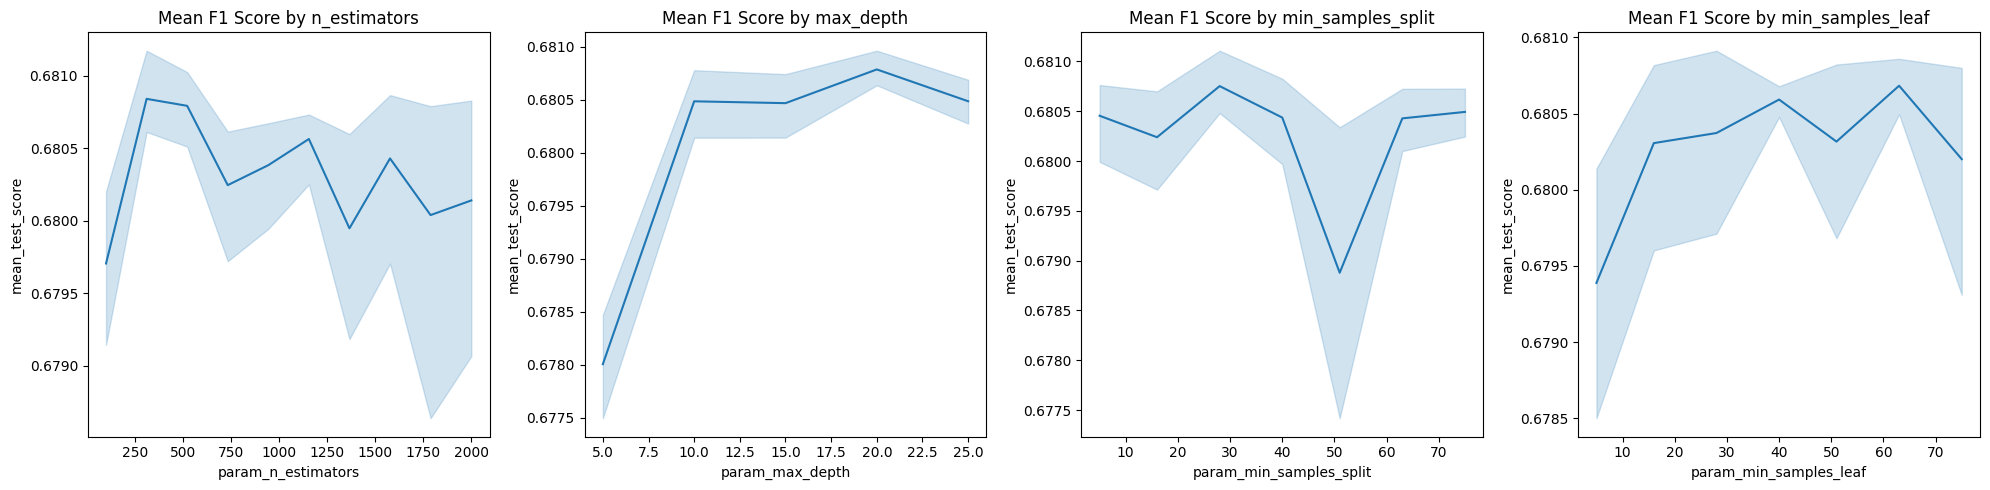

In [138]:
#Create plots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row 4 columns

# Plot n_estimators vs. mean F1 score
sns.lineplot(data=rf_random_tune_results, x='param_n_estimators', y='mean_test_score', ax=axs[0], estimator='mean')
axs[0].set_title('Mean F1 Score by n_estimators')

# Plot max_depth vs. mean F1 score
sns.lineplot(data=rf_random_tune_results, x='param_max_depth', y='mean_test_score', ax=axs[1], estimator='mean')
axs[1].set_title('Mean F1 Score by max_depth')

# Plot min_samples_split vs. mean F1 score
sns.lineplot(data=rf_random_tune_results, x='param_min_samples_split', y='mean_test_score', ax=axs[2], estimator='mean')
axs[2].set_title('Mean F1 Score by min_samples_split')

# Plot min_samples_leaf vs. mean F1 score
sns.lineplot(data=rf_random_tune_results, x='param_min_samples_leaf', y='mean_test_score', ax=axs[3], estimator='mean')
axs[3].set_title('Mean F1 Score by min_samples_leaf')

plt.tight_layout()
plt.show()

In [ ]:
#best_score = rf_random_grid.best_score_
#best_std = rf_random_grid.cv_results_['std_test_score'][rf_random_grid.best_index_]

# Define the one standard error threshold
#one_se_threshold = best_score - best_std

# Create a DataFrame of the results
#rf_random_tune_results = pd.DataFrame(rf_random_grid.cv_results_)

# Filter models within one SE of the best score
#candidates = rf_random_tune_results[rf_random_tune_results.mean_test_score >= one_se_threshold].sort_values(by='mean_test_score',ascending=False)
#candidates

In [ ]:
rf_random_tune_results = pd.DataFrame(rf_random_grid.cv_results_)

# Filter for ideal models based on graphs above
desired_models = rf_random_tune_results[
    (rf_random_tune_results['param_n_estimators'] >= 100) &
    (rf_random_tune_results['param_n_estimators'] <= 1300) &
    (rf_random_tune_results['param_max_depth'] >= 10) &
    (rf_random_tune_results['param_max_depth'] <= 15) &
    (rf_random_tune_results['param_min_samples_split'] <= 40) &
    (rf_random_tune_results['param_min_samples_split'] >= 25) &
    (rf_random_tune_results['param_min_samples_leaf'] <= 35) &
    (rf_random_tune_results['param_min_samples_leaf'] >= 10)
]

# Check if such exist and return it
if not desired_models.empty:
    print("Models found with the specified hyperparameters:")
    print(desired_models[['mean_test_score', 'std_test_score', 'rank_test_score']])
else:
    print("No models found with the exact specified hyperparameters.")

Since the model with the highest mean test score that also satisfies the filters is coincidentally the best performing model, we will choose this as our final model.

### Selecting and training the chosen model

In [139]:
#Index of the best model: 
best_model_index = rf_random_tune_results[rf_random_tune_results['rank_test_score'] == 1].index[0]
#Hyperparametervalues: 
best_model_params = rf_random_grid.cv_results_['params'][best_model_index]

#Creating the selected model
best_model = RandomForestClassifier(**best_model_params)

# Fit the model to your training data
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=28, min_samples_split=40,
                       n_estimators=311)

### Predictions and Evaluation

In [140]:
# We preprocess the testing set:
default_test_preprocessed = preprocess_data(default_test)

In [141]:

# make the predictors and actuals: 
X_test = default_test_preprocessed.drop(columns=['Default'])
y_test = default_test_preprocessed['Default']

In [161]:
# Predict and evaluate the model on the test set
y_pred = best_model.predict(X_test)

In [162]:
conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)

# Evaluation metrics:
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[46628 21081]
 [ 2797  6099]]
Accuracy: 0.6883
Sensitivity (Recall): 0.6856
Precision: 0.2244
F1 Score: 0.3381


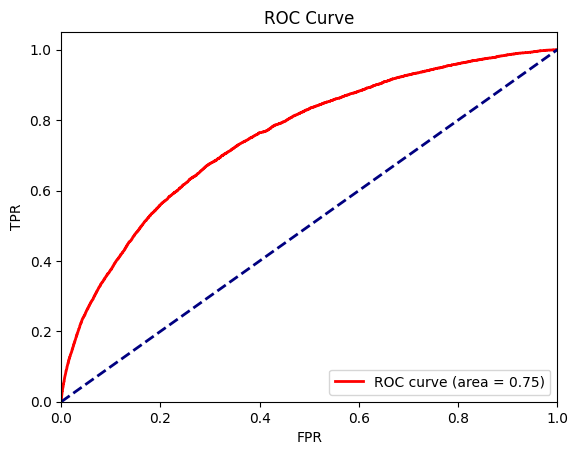

In [163]:
# ROC Curve and AUC score: 

#soft probabilities: 
y_scores = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Very poor score. We see we have a lot of False Positives, suggesing that we over predict the number of defaults. At the same time, we still miss over 30% of deaulting cases.

#### Feature Importance Scores

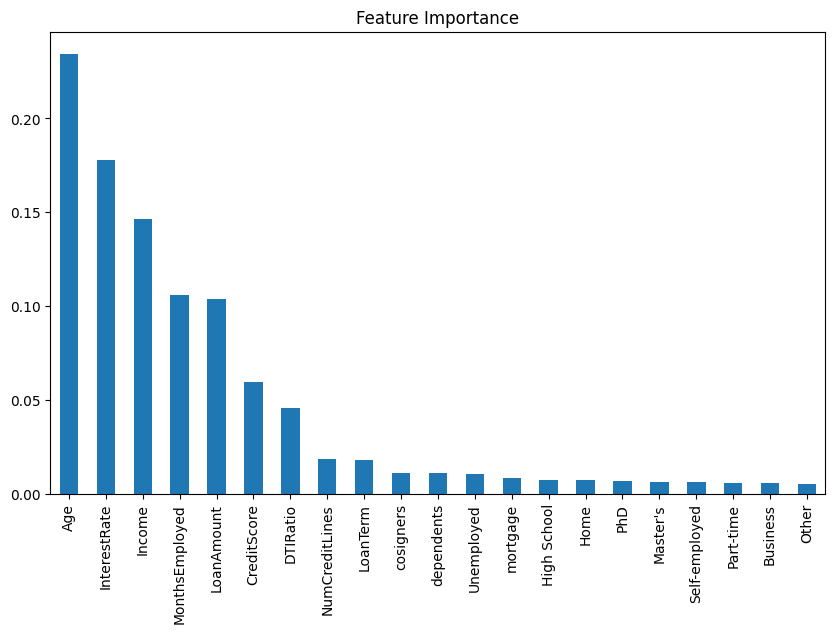

In [39]:
feature_importances = best_model.feature_importances_

# Get feature names:
feature_names = X_train.columns
# Match feature name with importance score: 
importances = pd.Series(feature_importances, index=feature_names)

# Sort in desc order: 
sorted_importances = importances.sort_values(ascending=False)

#plot 
plt.figure(figsize=(10,6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

In [ ]:
# Some ideas to improve:
# Remove variables with feature importance below 0.05 or 0.03...
# Perform SMOTE instead of downsampling
# Use A StandardScaler() on the X variables
# Ordinal encoding for Educ and other ordinal/cat vars


#### Custom Hyperparameter values:

In [40]:
#Choosing a custom selected model 
custom_hyperparameters = {
    'n_estimators': 1200,
    'min_samples_split': 25,
    'min_samples_leaf': 18,
    'max_features': 'sqrt',
    'max_depth': 15,
    'bootstrap': True
}
# Instantiate the custom model: 
custom_selected_model = RandomForestClassifier(**custom_hyperparameters)
# Fitting:
custom_selected_model.fit(X_train, y_train)
y_pred = custom_selected_model.predict(X_test)


In [41]:
# Evaluation: 
conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)

# Evaluation metrics:
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[46440 21269]
 [ 2777  6119]]
Accuracy: 0.6861
Sensitivity (Recall): 0.6878
Precision: 0.2234
F1 Score: 0.3373


## Error Analysis

In [45]:
X_test.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'mortgage',
       'dependents', 'cosigners', 'High School', 'Master's', 'PhD',
       'Part-time', 'Self-employed', 'Unemployed', 'Business', 'Home',
       'Other'],
      dtype='object')

In [61]:
# Add predictions and actuals to X_test
X_test_with_predictions = X_test.copy()
X_test_with_predictions['predicted'] = y_pred
X_test_with_predictions['actual'] = y_test

# Dummy for correct predictions: 
X_test_with_predictions['correct_prediction'] = X_test_with_predictions['predicted'] == X_test_with_predictions['actual']

In [62]:
def error_analysis(df,feature):
    # Missclassification rate per feature: 
    misclassification_rate = df.groupby(feature)['correct_prediction'].mean() 
    #error rate: 
    error_rate = 1 - misclassification_rate

    # Print & Plot
    #print(f"Error rate by {feature}:")
    #print(error_rate)
    
    error_rate.plot(kind='bar', figsize=(10, 6))
    plt.title(f"Error rate by feature")
    plt.ylabel('Error Rate')
    plt.xlabel('feature')
    plt.show()

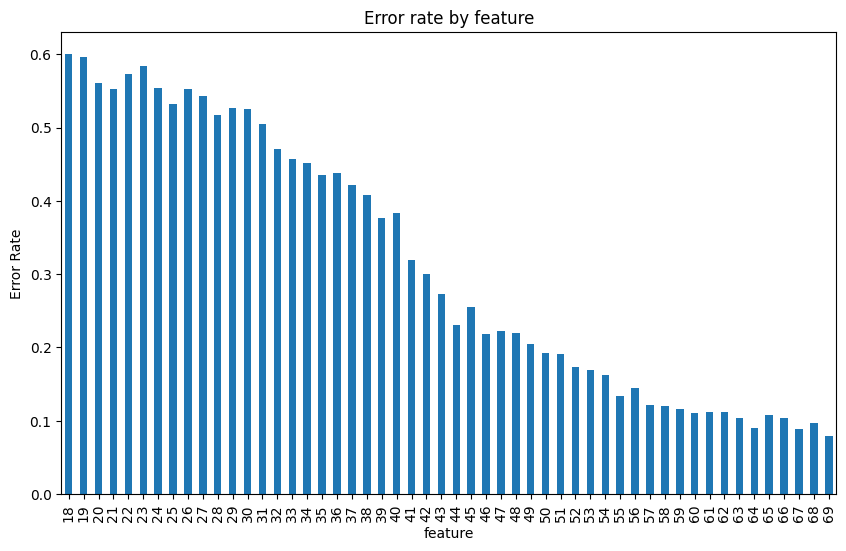

In [63]:
error_analysis(X_test_with_predictions,X_test['Age'])

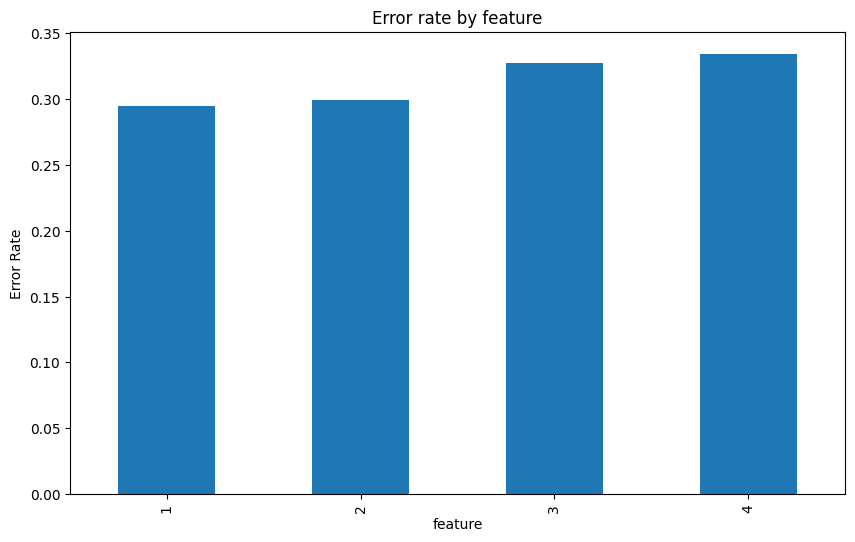

In [67]:
error_analysis(X_test_with_predictions,X_test['NumCreditLines'])

In [ ]:
# To do:
# CatBoost / Target Encoding
# Try Lasso 
